### Time Series Forecasting with Machine Learning


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
import optuna 
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score



C:\Users\USER\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sales = pd.read_csv('sales.csv') 
stores = pd.read_csv('stores.csv') 
holidays = pd.read_csv('holidays_events.csv')  

In [3]:
# Function to load and merge data
def load_and_merge_data(sales, holidays, stores):
     
    df = sales.merge(stores, on='store_nbr', how='left')
    df = df.merge(holidays, on='date', how='left')

    return df 

In [4]:
# Function to preprocess data
def preprocess_data(df):
    # Rename columns
    df = df.rename(columns={
        'store_nbr': 'store_number',
        'sale_amount': 'sales',
        'onpromotion': 'is_on_promotion',
        'type_x': 'store_type',
        'type_y': 'holiday_type',
        'locale': 'holiday_locale',
        'locale_name': 'holiday_name',
        'description': 'holiday_description',
        'transferred': 'is_holiday_transferred'
    })
    
    # Handle missing values
    df['is_holiday'] = df['holiday_type'].notnull()
    df['holiday_type'] = df['holiday_type'].fillna('Not a Holiday')
    df['holiday_locale'] = df['holiday_locale'].fillna('N/A')
    df['holiday_name'] = df['holiday_name'].fillna('N/A')
    df['holiday_description'] = df['holiday_description'].fillna('No Holiday')
    df['is_holiday_transferred'] = df['is_holiday_transferred'].fillna(False)
    
    # Ensure date column is datetime type
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    
    return df

In [5]:

def feature_engineering(df):
    # Extract time-based features
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['day_of_week'] = df.index.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    
    
    # One-hot encoding for categorical variables
    categorical_cols = ['category', 'city', 'state', 'store_type', 'holiday_type', 'holiday_locale']
    df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
    
    df_encoded = df_encoded.bfill()  # Backfill NaN values
    
    return df_encoded



In [6]:

def prepare_data_for_prediction(df_encoded):
    numeric_cols = df_encoded.select_dtypes(include=['number']).columns.tolist()
    categorical_cols = ['category', 'city', 'state', 'store_type', 'holiday_type', 'holiday_locale']
    encoded_categorical_cols = [col for col in df_encoded.columns if any(prefix in col for prefix in categorical_cols)]
    selected_features = numeric_cols + encoded_categorical_cols
    selected_features.remove('sales')
    
    X = df_encoded[selected_features]
    y = df_encoded['sales']
    return X, y


In [7]:
# Function to split data into train and test sets
def split_data(X, y, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    train_index, test_index = list(tscv.split(X))[-1]
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    return X_train, X_test, y_train, y_test

def split_data_by_date(X, y, split_date):
  
    # Split the data
    X_train = X[X.index <= split_date]
    X_test = X[X.index > split_date]
    y_train = y[y.index <= split_date]
    y_test = y[y.index > split_date]
    
    return X_train, X_test, y_train, y_test


In [8]:
# Function to scale data
def scale_data(X_train, X_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled

In [9]:
# Function to evaluate model
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, mae, r2

In [10]:
# Function to train and evaluate models
def train_and_evaluate_models(X_train_scaled, y_train, X_test_scaled, y_test):
    models = {
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42)  
}
    
    results = {}
    for name, model in models.items():
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        mse, mae, r2 = evaluate_model(y_test, y_pred)
        results[name] = {'MSE': mse, 'MAE': mae, 'R2': r2}
        print(f"{name} - MSE: {mse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")

    # Find the best model
    best_model_name = max(results, key=lambda x: results[x]['R2'])
    best_model = models[best_model_name]
    print(f"\nBest performing model: {best_model_name}")
    
    return best_model, results


## Preprocessing_pipeline

In [11]:
def preprocessing_pipeline(sales, holidays, stores, split_date=None):
    # Load and merge data
    df = load_and_merge_data(sales, holidays, stores)
    
    # Preprocess data
    df = preprocess_data(df)
    
    # Feature engineering
    df_encoded = feature_engineering(df)
    
    # Prepare data for prediction
    X, y = prepare_data_for_prediction(df_encoded)
    
    # Split data into train and test sets
    if split_date:
        X_train, X_test, y_train, y_test = split_data_by_date(X, y, split_date)
    else:
        X_train, X_test, y_train, y_test = split_data(X, y)
    
    # Scale data
    X_train_scaled, X_test_scaled = scale_data(X_train, X_test)

    return X_train_scaled, X_test_scaled, y_train, y_test, df_encoded




In [12]:
X_train_scaled, X_test_scaled, y_train, y_test, df_encoded = preprocessing_pipeline(sales, holidays, stores)

C:\Users\USER\AppData\Local\Temp\ipykernel_20464\3385249878.py:22: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['is_holiday_transferred'] = df['is_holiday_transferred'].fillna(False)


In [13]:
best_model, results = train_and_evaluate_models(
    X_train_scaled, y_train, X_test_scaled, y_test)  

XGBoost - MSE: 157855.7300, MAE: 130.6336, R2: 0.9209
RandomForest - MSE: 232653.2394, MAE: 102.1850, R2: 0.8834
GradientBoosting - MSE: 420928.4906, MAE: 266.2927, R2: 0.7891

Best performing model: XGBoost


##### Since XGB has shown significantly better performance compared to the other models, we will focus on fine-tuning this model. The other models do not warrant fine-tuning as they are unlikely to achieve performance levels comparable to XGB.

In [18]:

random_seed = 42 

# Define the objective function for Optuna
def objective(trial):
    # Set random seed for reproducibility
    random_seed = 42

    # Define the hyperparameter search space
    param_grid = {
        'n_estimators': trial.suggest_categorical('n_estimators', [50, 100, 150]),
        'max_depth': trial.suggest_int('max_depth', 3, 5),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),  # Updated to suggest_float with log=True
        'subsample': trial.suggest_float('subsample', 0.8, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.8, 1.0)
    }

    # Initialize the XGBoost model with the trial parameters
    xgb = XGBRegressor(random_state=random_seed, **param_grid)

    # Use TimeSeriesSplit for cross-validation
    tscv = TimeSeriesSplit(n_splits=5)
    scores = []

    for train_index, test_index in tscv.split(X_train_scaled):
        X_train_cv, X_test_cv = X_train_scaled[train_index], X_train_scaled[test_index]
        y_train_cv, y_test_cv = y_train.iloc[train_index], y_train.iloc[test_index]

        xgb.fit(X_train_cv, y_train_cv)
        y_pred_cv = xgb.predict(X_test_cv)
        r2 = r2_score(y_test_cv, y_pred_cv)
        scores.append(r2)

    return np.mean(scores)

# Create a study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Get the best parameters and best model
best_params = study.best_params
best_model = XGBRegressor(random_state=random_seed, **best_params)
best_model.fit(X_train_scaled, y_train)

# Evaluate the best model
y_pred = best_model.predict(X_test_scaled)
mse, mae, r2 = evaluate_model(y_test, y_pred)
print(f"Best model performance - MSE: {mse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")

[I 2024-11-21 21:40:41,927] A new study created in memory with name: no-name-a60f4376-f200-48ec-a3ce-a207df09a5bd
[I 2024-11-21 21:40:52,128] Trial 0 finished with value: 0.7081041176478238 and parameters: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.08725640838888556, 'subsample': 0.9581781534183282, 'colsample_bytree': 0.8229490037557152}. Best is trial 0 with value: 0.7081041176478238.
[I 2024-11-21 21:41:00,894] Trial 1 finished with value: 0.5818017723230933 and parameters: {'n_estimators': 50, 'max_depth': 4, 'learning_rate': 0.02692244748662173, 'subsample': 0.9033871638640042, 'colsample_bytree': 0.9201769640952517}. Best is trial 0 with value: 0.7081041176478238.
[I 2024-11-21 21:41:24,029] Trial 2 finished with value: 0.6652343347612485 and parameters: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.08026332803398752, 'subsample': 0.9155763299557016, 'colsample_bytree': 0.8858951824403596}. Best is trial 0 with value: 0.7081041176478238.
[I 2024-11-21 21:4

Best model performance - MSE: 207286.0835, MAE: 178.6030, R2: 0.8961


We will use the original XGBoost model for predictions, as the hyperparameter tuning did not yield better results than the original model.


In [19]:
# Train the XGBoost model with the original parameters
model = XGBRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# Predict using the trained model
y_pred_final = model.predict(X_test_scaled)

# Calculate performance metrics
mse_final = mean_squared_error(y_test, y_pred_final)
mae_final = mean_absolute_error(y_test, y_pred_final)
r2_final = r2_score(y_test, y_pred_final)

print(f"Final model performance - MSE: {mse_final:.4f}, MAE: {mae_final:.4f}, R2: {r2_final:.4f}")


Final model performance - MSE: 157855.7300, MAE: 130.6336, R2: 0.9209


Let's compare the predicted values with actual ones.

In [20]:
# Print actual vs predicted values for inspection
prediction = model.predict(X_test_scaled)
comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': prediction})
print(comparison_df.head(20))  # Display the first 20 rows

                 Actual    Predicted
date                                
2016-06-18    70.000000    51.257874
2016-06-18     1.000000   -28.950546
2016-06-18    88.220000    94.142189
2016-06-18   264.000000   188.670547
2016-06-18     4.000000   -46.508812
2016-06-18    61.607998   117.006927
2016-06-18    75.000000    66.921349
2016-06-18   796.152000   659.268677
2016-06-18     1.000000    99.065544
2016-06-18    15.000000    55.974571
2016-06-18  4949.000000  4297.368164
2016-06-18   731.130000   699.993042
2016-06-18    33.000000   139.975296
2016-06-18  1399.000000  1548.721680
2016-06-18  1489.000000  1326.434448
2016-06-18   444.297000   459.796783
2016-06-18   246.000000   241.084137
2016-06-18   305.800000   238.382050
2016-06-18  6419.000000  5522.986328
2016-06-18    47.000000    78.535248


Negative values are included in the prediction. To prevent negative predictions, we will set a base_score in the model.

In [46]:
model = XGBRegressor(n_estimators=100, random_state=42, base_score=0.1)  # base_score sets a lower bound
model.fit(X_train_scaled, y_train)

# Predict and evaluate
prediction = model.predict(X_test_scaled)
# y_pred = np.where(y_pred < 0, 0, y_pred)  # Additional safeguard
mse, mae, r2 = evaluate_model(y_test, y_pred)
print(f"XGBoost with base_score - MSE: {mse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")

print('*************************************')

comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': prediction})
print(comparison_df.head(20))

XGBoost with base_score - MSE: 207286.0835, MAE: 178.6030, R2: 0.8961
*************************************
                 Actual    Predicted
date                                
2016-06-18    70.000000    15.162359
2016-06-18     1.000000   -19.724871
2016-06-18    88.220000   139.410950
2016-06-18   264.000000   243.209610
2016-06-18     4.000000   -18.986456
2016-06-18    61.607998   319.124634
2016-06-18    75.000000    90.609810
2016-06-18   796.152000   830.574463
2016-06-18     1.000000    95.688606
2016-06-18    15.000000    41.631199
2016-06-18  4949.000000  4507.002441
2016-06-18   731.130000   651.924011
2016-06-18    33.000000   147.761703
2016-06-18  1399.000000  1476.319092
2016-06-18  1489.000000  1409.235107
2016-06-18   444.297000   576.406311
2016-06-18   246.000000   304.252380
2016-06-18   305.800000   428.692230
2016-06-18  6419.000000  5483.761230
2016-06-18    47.000000    74.420296


- Setting the base_score parameter in the XGBoost model can help improve the R2, MAE, and MSE metrics. 

- However, despite these improvements, we still observe negative predicted values in our results. To address this issue, we will implement a safeguard by replacing any negative predictions with zero, ensuring that our predictions remain valid and meaningful in the context of sales data.


In [47]:
# Replace negative predictions with zero
prediction = np.where(prediction < 0, 0, prediction)

# Recalculate performance metrics
mse_final = mean_squared_error(y_test, prediction)
mae_final = mean_absolute_error(y_test, prediction)
r2_final = r2_score(y_test, prediction)

print(f"Adjusted model performance after replacing negatives - MSE: {mse_final:.4f}, MAE: {mae_final:.4f}, R2: {r2_final:.4f}")


Adjusted model performance after replacing negatives - MSE: 148950.5694, MAE: 124.1565, R2: 0.9254


In [48]:

model = XGBRegressor(n_estimators=100, random_state=42, base_score=0.1)  # base_score sets a lower bound
model.fit(X_train_scaled, y_train)

# Predict
prediction = model.predict(X_test_scaled)
    
# Replace negative predictions with zero
prediction = np.where(prediction < 0, 0, prediction)



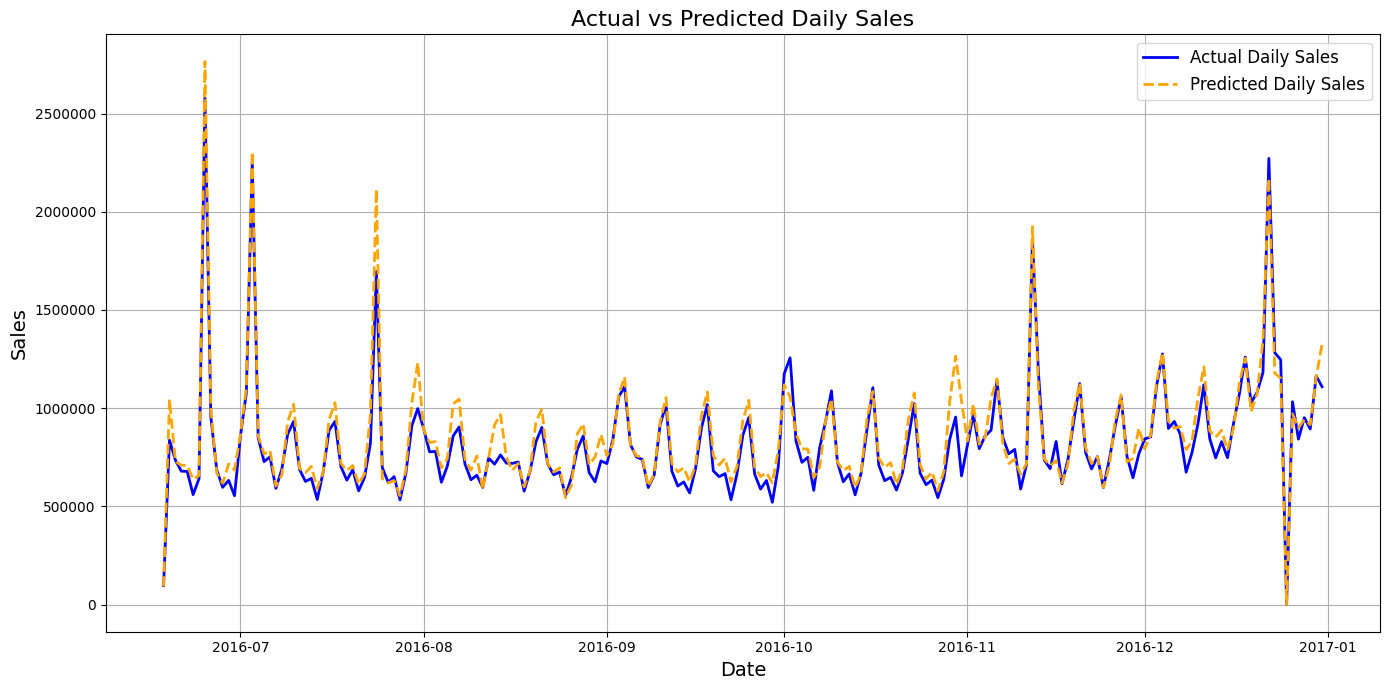

In [77]:
# Aggregate actual sales to daily totals
daily_actual = y_test.resample('D').sum()

# Aggregate predicted sales to daily totals
daily_predicted = pd.Series(prediction, index=y_test.index).resample('D').sum()

# Plotting function for daily sales
def plot_daily_sales(daily_actual, daily_predicted):
    plt.figure(figsize=(14, 7))
    
    # Plot actual daily sales
    plt.plot(daily_actual.index, daily_actual, label='Actual Daily Sales', color='blue', linewidth=2)
    
    # Plot predicted daily sales
    plt.plot(daily_predicted.index, daily_predicted, label='Predicted Daily Sales', color='orange', linestyle='--', linewidth=2)
    
    # Customize the plot
    plt.title('Actual vs Predicted Daily Sales', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Sales', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    
    # Format y-axis to show actual numbers instead of scientific notation
    plt.ticklabel_format(style='plain', axis='y')
    
    # Show the plot
    plt.tight_layout()
    plt.show()

# Call the function with daily aggregated data
plot_daily_sales(daily_actual, daily_predicted)

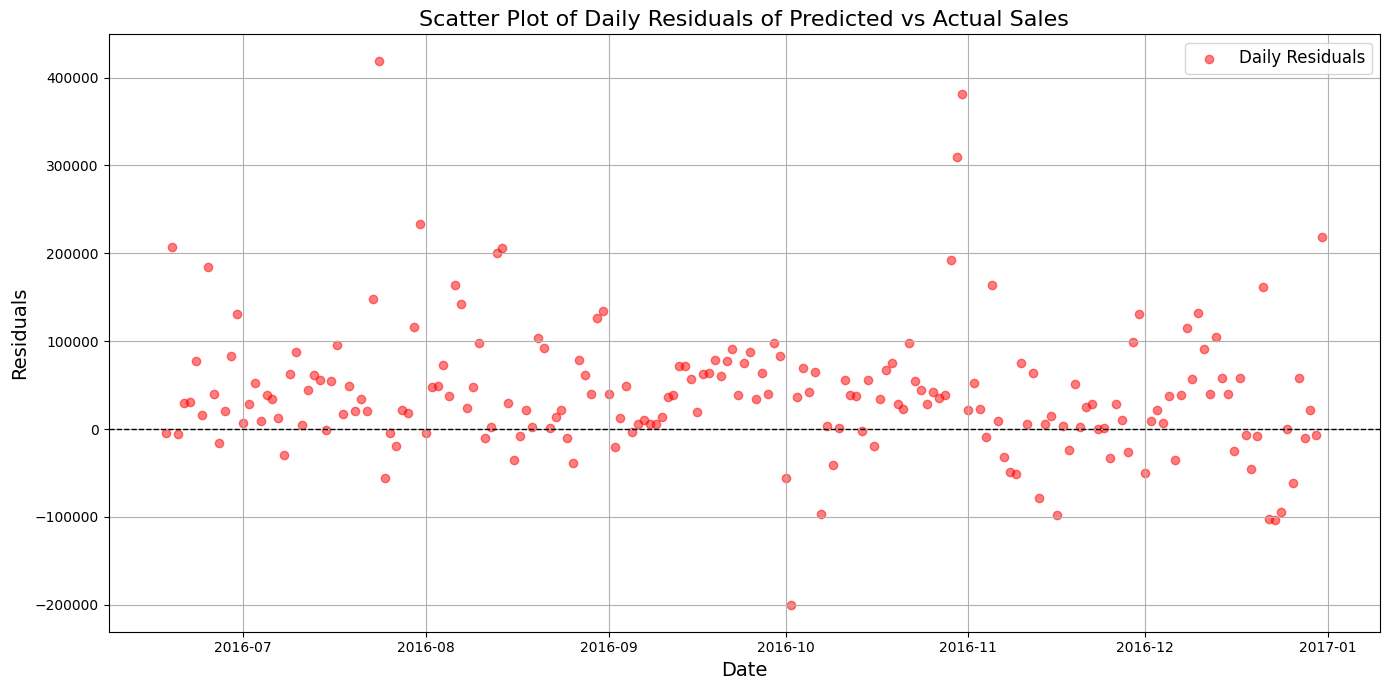

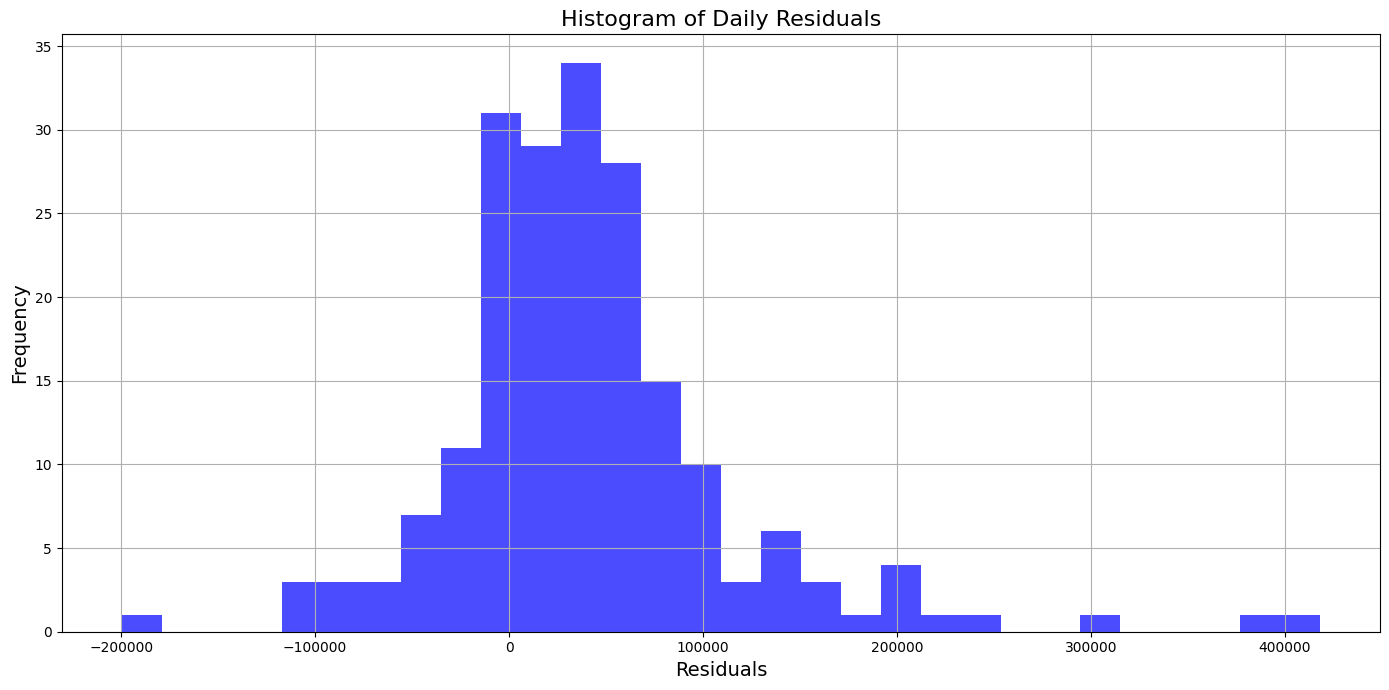

In [78]:
# Calculate daily residuals
daily_residuals = daily_predicted - daily_actual 

# Create a DataFrame for daily residuals
daily_residuals_df = pd.DataFrame({'Actual': daily_actual, 'Predicted': daily_predicted, 'Residuals': daily_residuals})

# Plotting daily residuals with scatter plot
plt.figure(figsize=(14, 7))
plt.scatter(daily_residuals_df.index, daily_residuals_df['Residuals'], color='red', alpha=0.5, label='Daily Residuals')
plt.axhline(0, color='black', linestyle='--', linewidth=1)  # Add a horizontal line at 0
plt.title('Scatter Plot of Daily Residuals of Predicted vs Actual Sales', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

# Show the scatter plot
plt.tight_layout()
plt.show()

# Plotting histogram of residuals
plt.figure(figsize=(14, 7))
plt.hist(daily_residuals_df['Residuals'], bins=30, color='blue', alpha=0.7)
plt.title('Histogram of Daily Residuals', fontsize=16)
plt.xlabel('Residuals', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True)

# Show the histogram
plt.tight_layout()
plt.show()


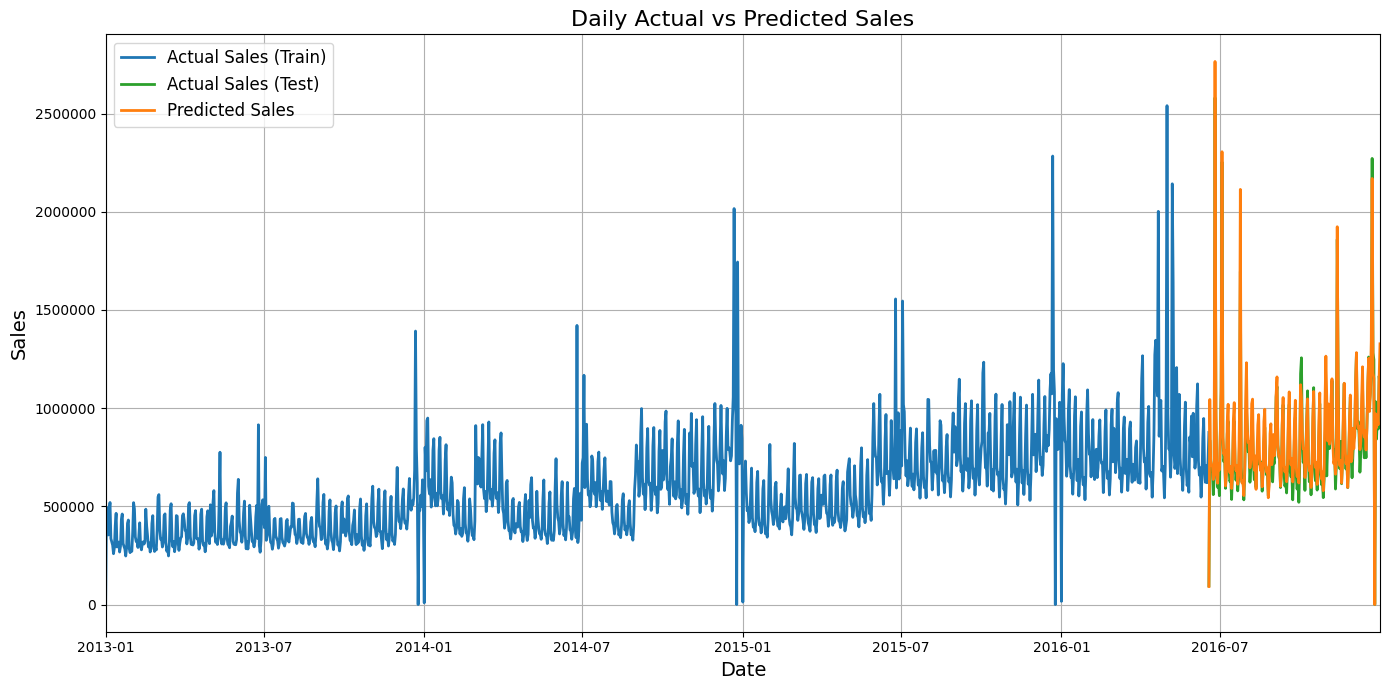

In [79]:
# Resample y_train and y_test to daily frequency
y_train_daily = y_train.resample('D').sum()
y_test_daily = y_test.resample('D').sum()

# Plotting daily actual and predicted sales in a single plot
plt.figure(figsize=(14, 7))
plt.plot(y_train_daily.index, y_train_daily, color='#1f77b4', label='Actual Sales (Train)', linewidth=2)  # Blue
plt.plot(y_test_daily.index, y_test_daily, color='#2ca02c', label='Actual Sales (Test)', linewidth=2)  # Green
plt.plot(daily_predicted.index, daily_predicted, color='#ff7f0e', label='Predicted Sales', linewidth=2)  # Orange
plt.title('Daily Actual vs Predicted Sales', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Sales', fontsize=14)
plt.ticklabel_format(style='plain', axis='y')  # Show y-axis with real numbers, not scientific notation
plt.xlim(min(y_train_daily.index.min(), y_test_daily.index.min()), max(y_train_daily.index.max(), y_test_daily.index.max()))  # Set x-axis limits to include both
plt.legend(fontsize=12)
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

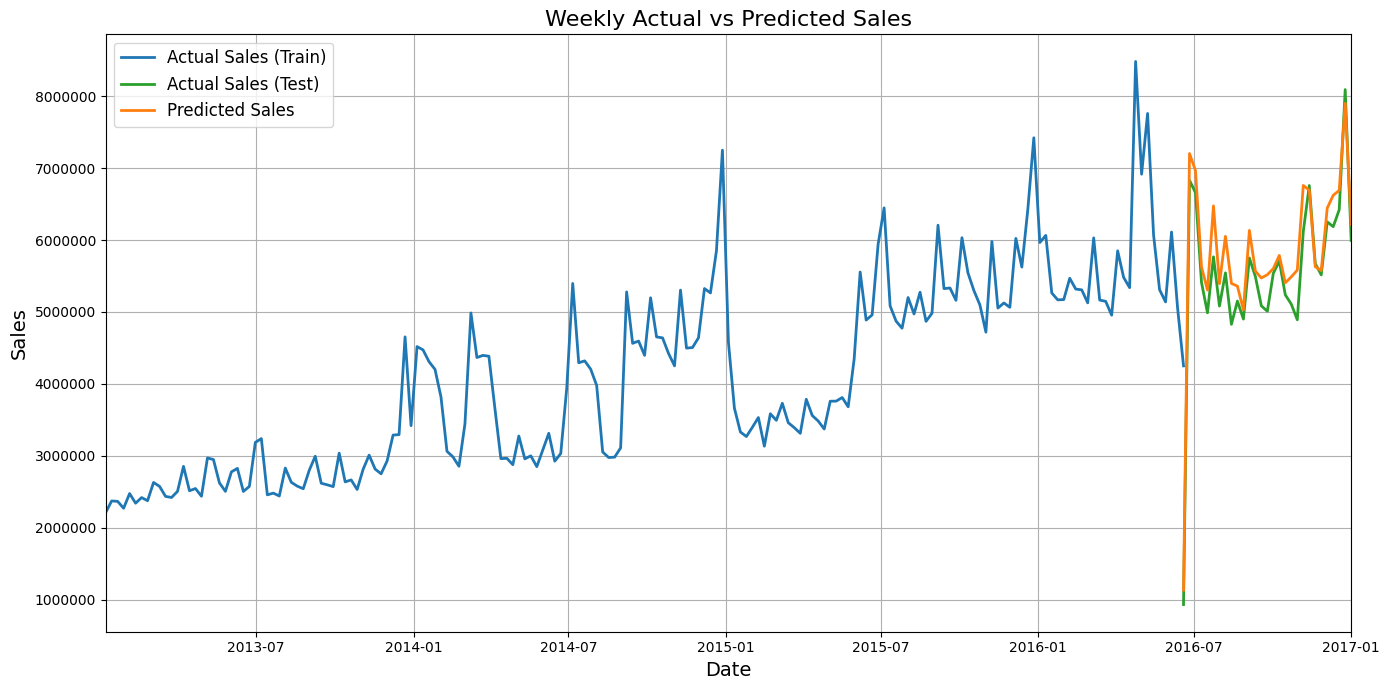

In [80]:
# Resample y_train and y_test to weekly frequency
y_train_weekly = y_train.resample('W').sum()
y_test_weekly = y_test.resample('W').sum()
weekly_predicted = daily_predicted.resample('W').sum()

# Plotting weekly actual and predicted sales in a single plot
plt.figure(figsize=(14, 7))
plt.plot(y_train_weekly.index, y_train_weekly, color='#1f77b4', label='Actual Sales (Train)', linewidth=2)  # Include y_train
plt.plot(y_test_weekly.index, y_test_weekly, color='#2ca02c', label='Actual Sales (Test)', linewidth=2)  # Include y_test
plt.plot(weekly_predicted.index, weekly_predicted, color='#ff7f0e', label='Predicted Sales', linewidth=2)
plt.title('Weekly Actual vs Predicted Sales', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Sales', fontsize=14)
plt.ticklabel_format(style='plain', axis='y')  # Show y-axis with real numbers, not scientific notation
plt.xlim(min(y_train_weekly.index.min(), y_test_weekly.index.min()), max(y_train_weekly.index.max(), y_test_weekly.index.max()))  # Set x-axis limits to include both
plt.legend(fontsize=12)
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


### Predicut Future Sales


We have trained our model using our data from 2013 to 2016.
Now we want to predict the future for 2017. We don't have any data about that.
But to predict using above model, we need some categorical data. For this purpose we created dummy categorical data for future dates based on the data from 2013 to 2016. For sale value, we set as zero ( that are going to be predicted by model).

Simply to say, we created the same dataset for future prediction using dummy categorical data.

The idea is 
- future dataset will append to the original dataset.
- then we will use the same preprocessing pipeline to preprocess the whole dataset.
- then we will use the whole historical data (up to Dec 2016) as training data and the future data ( after 2016 December ) as test data.

- then we will use the same model to predict the future sales.


In [81]:
future_simulation_data = pd.read_csv('future_dataset.csv')
future_simulation_data.head()


,id,date,store_nbr,category,sale_amount,onpromotion
0,1718283,2017-01-01,25,AUTOMOTIVE,0,0
1,1718284,2017-01-01,25,BABY CARE,0,0
2,1718285,2017-01-01,25,BEAUTY,0,0
3,1718286,2017-01-01,25,BEVERAGES,0,38
4,1718287,2017-01-01,25,BREAD/BAKERY,0,3


In [82]:
sales.head()

,id,date,store_nbr,category,sale_amount,onpromotion
0,1,2013-01-01,25,BEAUTY,2.000,0
1,2,2013-01-01,25,BEVERAGES,810.000,0
2,3,2013-01-01,25,BREAD/BAKERY,180.589,0
3,4,2013-01-01,25,CLEANING,186.000,0
4,5,2013-01-01,25,DAIRY,143.000,0


In [83]:
combine_df = pd.concat([sales, future_simulation_data], axis=0)
combine_df.head()

,id,date,store_nbr,category,sale_amount,onpromotion
0,1,2013-01-01,25,BEAUTY,2.000,0
1,2,2013-01-01,25,BEVERAGES,810.000,0
2,3,2013-01-01,25,BREAD/BAKERY,180.589,0
3,4,2013-01-01,25,CLEANING,186.000,0
4,5,2013-01-01,25,DAIRY,143.000,0


In [84]:
# Preprocess combined data
from datetime import datetime

split_date = datetime(2016, 12, 31)  # Using the datetime function to create the date
X_train_scaled_f, X_test_scaled_f, y_train_f, y_test_f, df_encoded = preprocessing_pipeline(combine_df, holidays, stores, split_date=split_date)


import xgboost as xgb

# Build the XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)

# Train the model
xgb_model.fit(X_train_scaled_f, y_train_f)

# Predict on the test data
predicted_sales = xgb_model.predict(X_test_scaled_f)
predicted_sales = np.where(predicted_sales < 0, 0, predicted_sales)


C:\Users\USER\AppData\Local\Temp\ipykernel_20464\3385249878.py:22: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['is_holiday_transferred'] = df['is_holiday_transferred'].fillna(False)


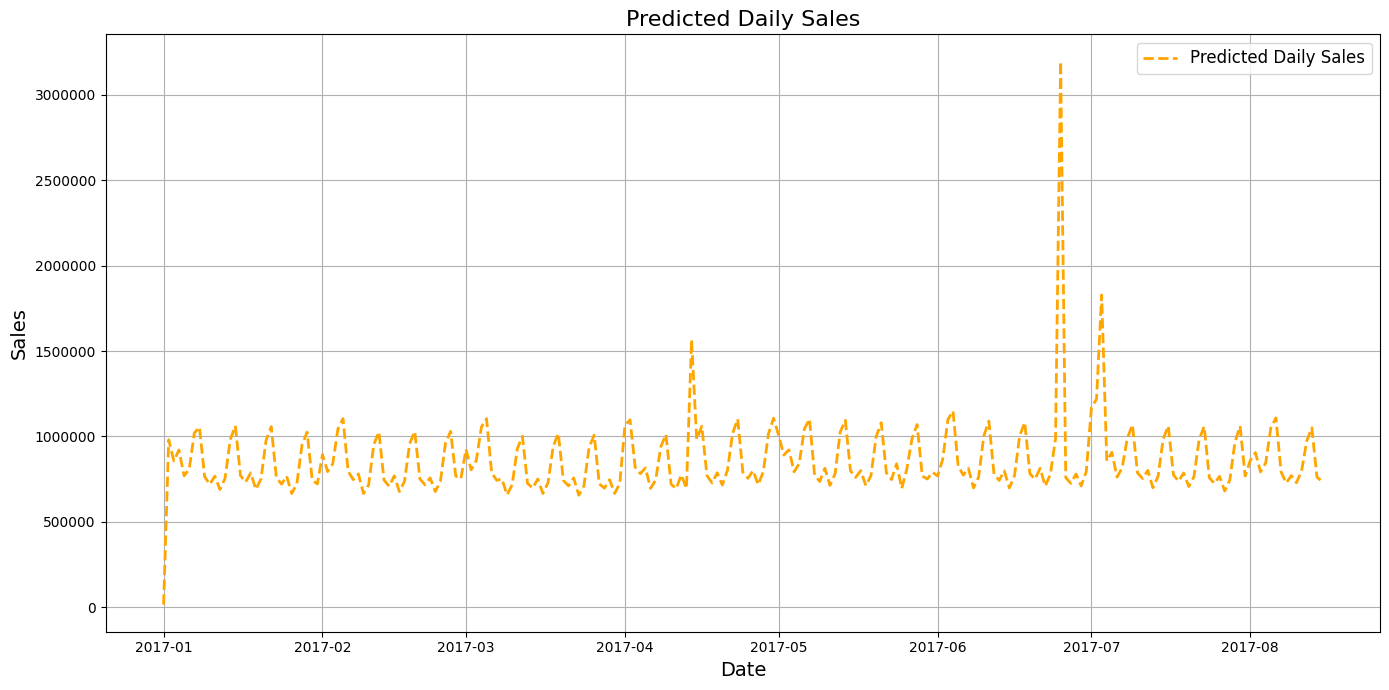

In [85]:

daily_predicted = pd.Series(predicted_sales, index=y_test_f.index).resample('D').sum()


plt.figure(figsize=(14, 7))

plt.plot(daily_predicted.index, daily_predicted, label='Predicted Daily Sales', color='orange', linestyle='--', linewidth=2)
    
# Customize the plot
plt.title('Predicted Daily Sales', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Sales', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
    

plt.ticklabel_format(style='plain', axis='y')
    

plt.tight_layout()
plt.show()


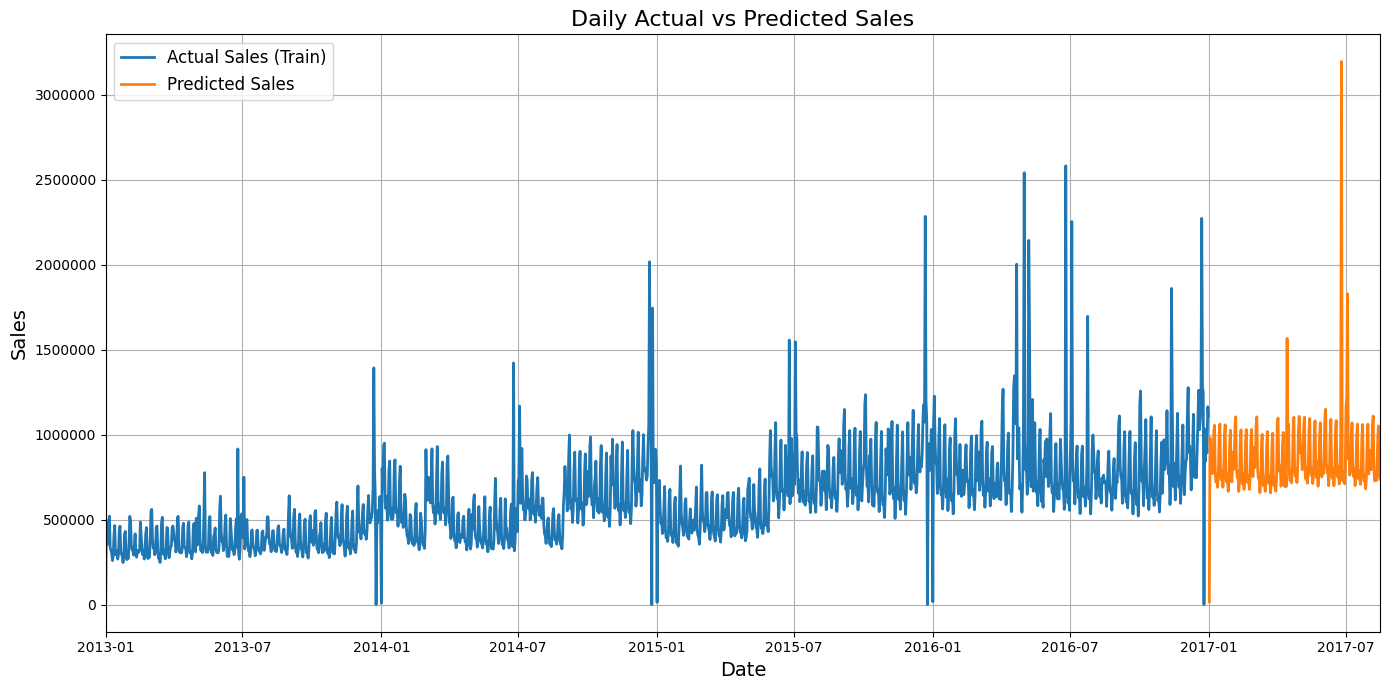

In [86]:
# Resample y_train and y_test to daily frequency
y_train_daily = y_train_f.resample('D').sum()
y_test_daily = y_test_f.resample('D').sum()

# Plotting daily actual and predicted sales in a single plot
plt.figure(figsize=(14, 7))
plt.plot(y_train_daily.index, y_train_daily, color='#1f77b4', label='Actual Sales (Train)', linewidth=2)  # Include y_train
#plt.plot(y_test_daily.index, y_test_daily, color='green', label='Actual Sales (Test)', linewidth=2)  # Include y_test
plt.plot(daily_predicted.index, daily_predicted, color='#ff7f0e', label='Predicted Sales', linewidth=2)
plt.title('Daily Actual vs Predicted Sales', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Sales', fontsize=14)
plt.ticklabel_format(style='plain', axis='y')  # Show y-axis with real numbers, not scientific notation
plt.xlim(min(y_train_daily.index.min(), y_test_daily.index.min()), max(y_train_daily.index.max(), y_test_daily.index.max()))  # Set x-axis limits to include both
plt.legend(fontsize=12)
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


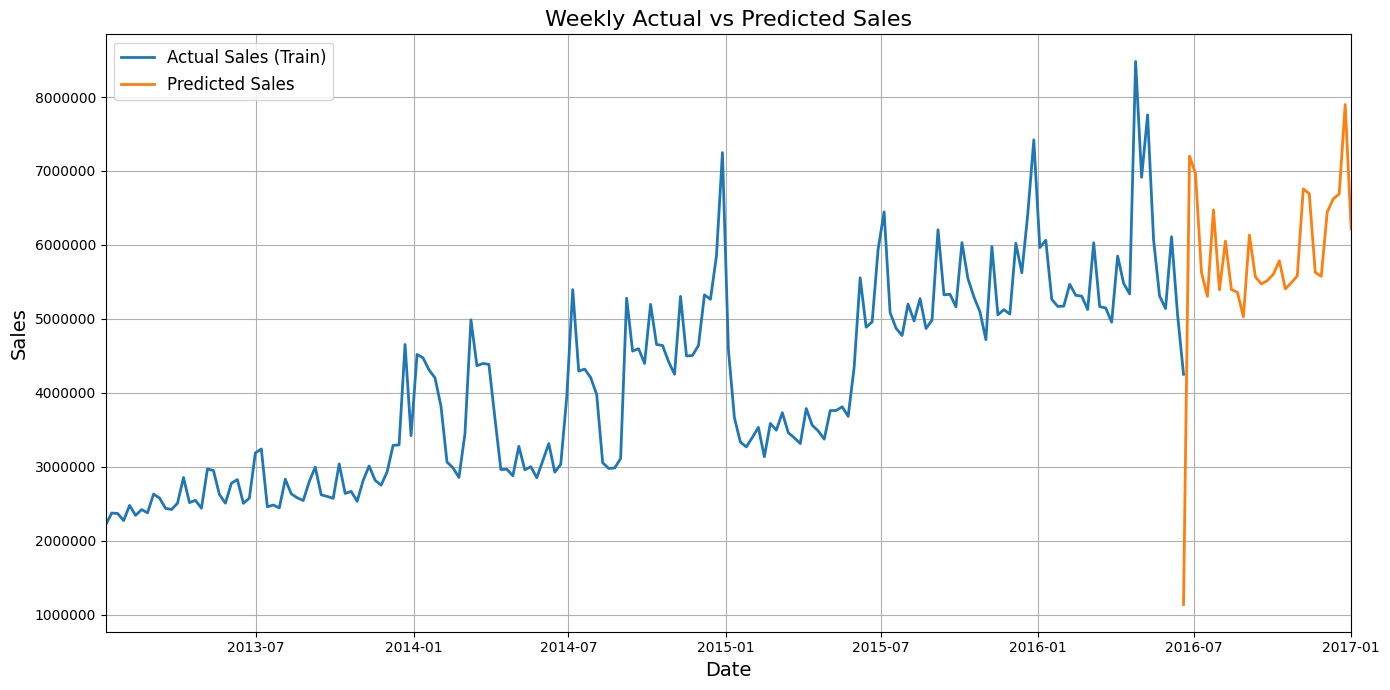

In [87]:
import matplotlib.pyplot as plt

# Plotting weekly actual and predicted sales in a single plot
plt.figure(figsize=(14, 7))

# Plot actual sales (train)
plt.plot(y_train_weekly.index, y_train_weekly, color='#1f77b4', label='Actual Sales (Train)', linewidth=2)

# Plot predicted sales
plt.plot(weekly_predicted.index, weekly_predicted, color='#ff7f0e', label='Predicted Sales', linewidth=2)

plt.title('Weekly Actual vs Predicted Sales', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Sales', fontsize=14)
plt.ticklabel_format(style='plain', axis='y')  # Show y-axis with real numbers, not scientific notation
plt.xlim(min(y_train_weekly.index.min(), weekly_predicted.index.min()), max(y_train_weekly.index.max(), weekly_predicted.index.max()))  # Set x-axis limits to include both
plt.legend(fontsize=12)
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

First point and last point of the predicted data are too low, let's check

In [88]:
#
# Create a DataFrame for the weekly predicted values
weekly_predicted_df = pd.DataFrame(weekly_predicted).reset_index()
weekly_predicted_df.columns = ['Date', 'Predicted Sales']

# Display the DataFrame with real numbers
print(weekly_predicted_df.to_string(index=False, float_format='%.2f'))


      Date  Predicted Sales
2016-06-19       1135925.38
2016-06-26       7201731.00
2016-07-03       6964912.00
2016-07-10       5626259.50
2016-07-17       5304417.00
2016-07-24       6473997.00
2016-07-31       5392459.50
2016-08-07       6051515.00
2016-08-14       5396777.00
2016-08-21       5358655.00
2016-08-28       5028662.00
2016-09-04       6133325.00
2016-09-11       5567455.00
2016-09-18       5472092.00
2016-09-25       5517819.50
2016-10-02       5603705.50
2016-10-09       5785584.50
2016-10-16       5405242.50
2016-10-23       5488087.00
2016-10-30       5582304.00
2016-11-06       6758493.50
2016-11-13       6692626.00
2016-11-20       5628738.00
2016-11-27       5575168.00
2016-12-04       6444342.50
2016-12-11       6621619.00
2016-12-18       6689647.50
2016-12-25       7899317.50
2017-01-01       6213815.00


Remove the first point and last point that are not calculated for the whole week ( 7 days ). Let's display that are calculated for whole week

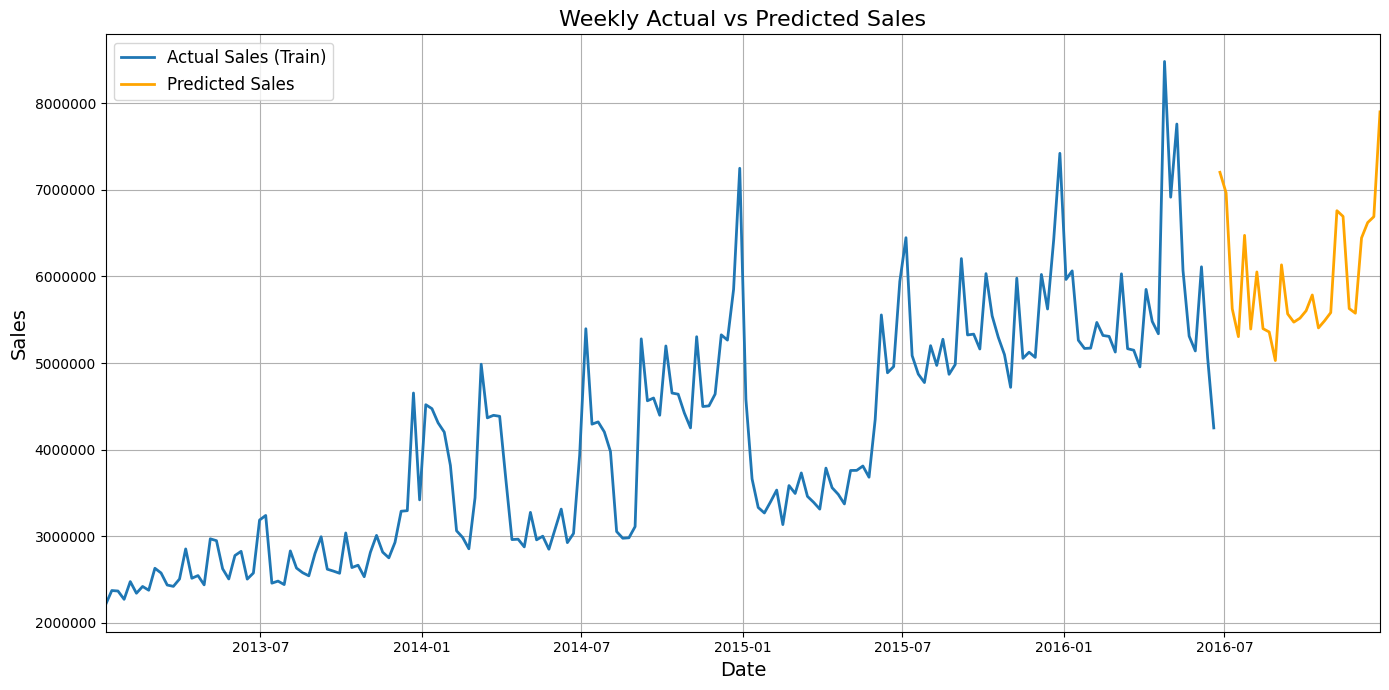

In [89]:
# Omit the first and last week of predicted sales
weekly_predicted = weekly_predicted.iloc[1:-1]

# Plotting weekly actual and predicted sales in a single plot
plt.figure(figsize=(14, 7))

# Plot actual sales (train)
plt.plot(y_train_weekly.index, y_train_weekly, color='#1f77b4', label='Actual Sales (Train)', linewidth=2)

# Plot predicted sales starting from the second week and excluding the last week
plt.plot(weekly_predicted.index, weekly_predicted, color='orange', label='Predicted Sales', linewidth=2)

plt.title('Weekly Actual vs Predicted Sales', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Sales', fontsize=14)
plt.ticklabel_format(style='plain', axis='y')  # Show y-axis with real numbers, not scientific notation
plt.xlim(min(y_train_weekly.index.min(), weekly_predicted.index.min()), max(y_train_weekly.index.max(), weekly_predicted.index.max()))  # Set x-axis limits to include both
plt.legend(fontsize=12)
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()